# Tree Create

In [6]:
from math import log
import operator

# 计算香农熵
def calcShannonEnt(dataSet):
    numEnt = len(dataSet)
    labelCount = {}
    for data in dataSet:
        labelCount[data[-1]] = labelCount.get(data[-1], 0) + 1
    shannonEnt = 0.0
    for l in labelCount.values():
        shannonEnt -= l / numEnt * log(l / numEnt, 2)
    return shannonEnt

# 实例数据集
def createDataSet():
    dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataSet, labels


def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for data in dataSet:
        if data[axis] == value:
            retData = data[:axis] + data[axis+1:]
            retDataSet.append(retData)
    return retDataSet

# 选择 信息增益 最大的特征
def chooseBestFeature(dataSet):
    numFeat = len(dataSet[0]) - 1
    baseEnt = calcShannonEnt(dataSet)
    bestFeat = -1
    bestInfoGain = 0.0
    for i in range(numFeat):
        featValue = [x[i] for x in dataSet]
        featValue = set(featValue)
        newShannonEnt = 0.0
        for val in featValue:
            subDataSet = splitDataSet(dataSet, i, val)
            prop = len(subDataSet) / len(dataSet)
            newShannonEnt += prop * calcShannonEnt(subDataSet)
        if baseEnt - newShannonEnt > bestInfoGain:
            bestFeat = i
            bestInfoGain = baseEnt - newShannonEnt
    return bestFeat

# 多数表决
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        classCount[vote] = classCount.get(vote, 0) + 1
        sortedClassCount = sorted(classCount.items, key = operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

# 根据数据集 生成树
def createTree(dataSet, labels):
    classList = [x[-1] for x in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    bestFeat = chooseBestFeature(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeat])
    featValues = [x[bestFeat] for x in dataSet]
    featValues = set(featValues)
    for val in featValues:
        subLabels = labels[:]
        myTree[bestFeatLabel][val] = createTree(splitDataSet(dataSet, bestFeat, val), subLabels)
    return myTree
    

In [7]:
myData, labels = createDataSet()
myTree = createTree(myData, labels)

In [8]:
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# Tree Plot

In [9]:
import matplotlib.pyplot as plt

# 获取树的叶子节点数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

# 获取树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        keyDepth = 0
        if type(secondDict[key]).__name__ == 'dict':
            keyDepth = getTreeDepth(secondDict[key]) + 1
        else:
            keyDepth = 1
        if keyDepth > maxDepth:
            maxDepth = keyDepth
    return maxDepth

decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

#def createPlot():
#    fig = plt.figure(1, facecolor='white')
#    fig.clf()
#    createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
#    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
#    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
#    plt.show()

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

#createPlot(thisTree)

3 2


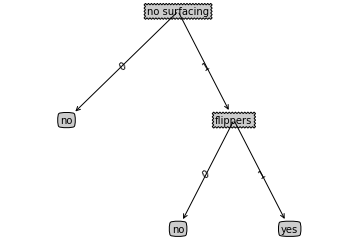

In [12]:
numLeafs = getNumLeafs(myTree)
treeDepth = getTreeDepth(myTree)
print(numLeafs, treeDepth)
createPlot(myTree)

# Save to file (use pickle)

In [13]:
def storeTree(inputTree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    with open(filename,'rb') as fr:
        return pickle.load(fr)
    
storeTree(myTree, 'treeStored.txt')
getTree = grabTree('treeStored.txt')
getTree   

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# Example (lenses dataset)

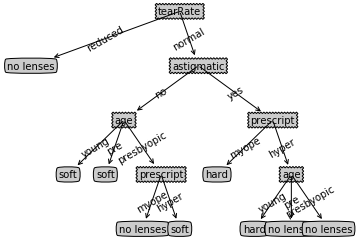

In [15]:
with open('lenses.txt') as fr:
    lenses = [s.strip().split('\t') for s in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
createPlot(lensesTree)